In [1]:
library(ArchR)
library(parallel)
library(Seurat)
addArchRThreads(threads = 16) 
addArchRGenome('hg38')

Loading required package: ggplot2

Warning message:
“package ‘ggplot2’ was built under R version 4.1.3”
Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats

Warning message:
“package ‘matrixStats’ was built under R version 4.1.3”

Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    r

In [2]:
setwd('/storage/groups/ml01/workspace/laura.martens/atac_poisson_data/benchmark/neurips/archr/')

In [173]:
proj <- ArchRProject(
  ArrowFiles = list.files(pattern = '*arrow')[2:length(list.files(pattern = '*arrow'))], 
  outputDirectory = "neurips",
  copyArrows = FALSE #This is recommened so that you maintain an unaltered copy for later usage.
)

Using GeneAnnotation set by addArchRGenome(Hg38)!

Using GeneAnnotation set by addArchRGenome(Hg38)!

Validating Arrows...

Getting SampleNames...



Getting Cell Metadata...



Merging Cell Metadata...

Initializing ArchRProject...


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,-

In [178]:
proj


           ___      .______        ______  __    __  .______      
          /   \     |   _  \      /      ||  |  |  | |   _  \     
         /  ^  \    |  |_)  |    |  ,----'|  |__|  | |  |_)  |    
        /  /_\  \   |      /     |  |     |   __   | |      /     
       /  _____  \  |  |\  \\___ |  `----.|  |  |  | |  |\  \\___.
      /__/     \__\ | _| `._____| \______||__|  |__| | _| `._____|
    



class: ArchRProject 
outputDirectory: /storage/groups/ml01/workspace/laura.martens/atac_poisson_data/benchmark/neurips/archr/neurips 
samples(14): s1d1 s1d2 ... s4d8 s4d9
sampleColData names(1): ArrowFiles
cellColData names(13): Sample TSSEnrichment ... nDiFrags BlacklistRatio
numberOfCells(1): 189460
medianTSS(1): 12.721
medianFrags(1): 4253

In [179]:
metadata <- fread('../metadata.csv', header=TRUE)

In [193]:
unique(metadata[['batch']])

[1] "s1d1"  "s1d2"  "s1d3"  "s2d1"  "s2d4"  "s2d5"  "s3d10" "s3d3"  "s3d6" 
[10] "s3d7"  "s4d1"  "s4d8"  "s4d9"

In [180]:
cellnames <- as.data.frame(str_split(metadata[['V1']], '-', simplify=TRUE))
colnames(cellnames) <- c('barcode', 'sample', 'batch')

In [182]:
cellnames[cellnames[,3] == "",3] <- 's2d4'
cellnames[cellnames[,2] == "s2d4",2] <- '5'

In [183]:
table(cellnames[['batch']], cellnames[['sample']])

       
           1   10   12   13   14    2    3    4    5    6    8
  s1d1  5616    0    0    0    0    0    0    0    0    0    0
  s1d2     0    0    0    0    0 6069    0    0    0    0    0
  s1d3     0    0    0    0    0    0 3875    0    0    0    0
  s2d1     0    0    0    0    0    0    0 3811    0    0    0
  s2d4     0    0    0    0    0    0    0    0 5456    0    0
  s2d5     0    0    0    0    0    0    0    0    0 4395    0
  s3d10    0 3909    0    0    0    0    0    0    0    0    0
  s3d3     0    0    0    0    0    0    0    0    0    0 1496
  s3d6     0    0 1771    0    0    0    0    0    0    0    0
  s3d7     0    0    0    0 6094    0    0    0    0    0    0
  s4d1     0    0    0 7235    0    0    0    0    0    0    0
  s4d8     0    0    0    0 8875    0    0    0    0    0    0
  s4d9     0    0 3899    0    0    0    0    0    0    0    0

In [201]:
cellnames[['full_barcode']] <- str_c(cellnames[['barcode']] ,cellnames[['sample']] ,cellnames[['batch']], sep='-')

In [202]:
head(cellnames)

,barcode,sample,batch,full_barcode
,<chr>,<chr>,<chr>,<chr>
1,TAGTTGTCACCCTCAC,1,s1d1,TAGTTGTCACCCTCAC-1-s1d1
2,CTATGGCCATAACGGG,1,s1d1,CTATGGCCATAACGGG-1-s1d1
3,CCGCACACAGGTTAAA,1,s1d1,CCGCACACAGGTTAAA-1-s1d1
4,TCATTTGGTAATGGAA,1,s1d1,TCATTTGGTAATGGAA-1-s1d1
5,ACCACATAGGTGTCCA,1,s1d1,ACCACATAGGTGTCCA-1-s1d1
6,TGGATTGGTTTGCGAA,1,s1d1,TGGATTGGTTTGCGAA-1-s1d1


In [175]:
library(stringr)

In [189]:
#cellnames <- str_split(proj$cellNames, '-', simplify=TRUE)[,1]
cellnames_archr <- as.data.frame(str_split(proj$cellNames, '#|-', simplify=TRUE))
colnames(cellnames_archr) <- c('batch', 'barcode', 'sample')

In [195]:
library(dplyr)
cellnames_archr <- cellnames_archr %>% mutate(sample = 
recode(batch, 's1d1'='1', 's1d2'='2', 's1d3'='3', 's2d1'='4', 's2d4'='5', 's2d5'='6', 's3d6'='12', 's3d7'='14', 's3d3'='8', 's3d10'='10', 's4d9'='12', 's4d1'='13', 's4d8'='14')) 

In [203]:
cellnames_archr[['full_barcode']] <- str_c(cellnames_archr[['barcode']],cellnames_archr[['sample']] ,cellnames_archr[['batch']], sep='-')

In [204]:
head(cellnames_archr)

,batch,barcode,sample,full_barcode
,<chr>,<chr>,<chr>,<chr>
1,s1d1,GTTAAGTGTAACCACA,1,GTTAAGTGTAACCACA-1-s1d1
2,s1d1,ATGCCTGAGCATTATG,1,ATGCCTGAGCATTATG-1-s1d1
3,s1d1,TAGCAGGCACAGCCAT,1,TAGCAGGCACAGCCAT-1-s1d1
4,s1d1,CCTACTTCATAGGCGA,1,CCTACTTCATAGGCGA-1-s1d1
5,s1d1,TTTGTTGGTCACACCC,1,TTTGTTGGTCACACCC-1-s1d1
6,s1d1,TTGGATTCACAAAGAC,1,TTGGATTCACAAAGAC-1-s1d1


In [205]:
nrow(cellnames_archr)

[1] 189460

In [206]:
nrow(cellnames)

[1] 62501

In [208]:
length(unique(cellnames_archr[['full_barcode']]))

[1] 189460

In [209]:
length(unique(cellnames[['full_barcode']]))

[1] 62501

In [210]:
length(cellnames_archr[['full_barcode']][cellnames_archr[['full_barcode']] %in% cellnames[['full_barcode']]])

[1] 49329

In [101]:
proj <- proj[cells]

In [113]:
proj$barcodes = str_c(test2[['barcode']], test2[['sample.x']], sep='-')

# Dimensionality reduction

In [102]:
proj <- addIterativeLSI(ArchRProj = proj, useMatrix = "TileMatrix", name = "IterativeLSI")

Checking Inputs...

ArchR logging to : ArchRLogs/ArchR-addIterativeLSI-106fed84ce58-Date-2022-06-27_Time-14-40-34.log
If there is an issue, please report to github with logFile!

2022-06-27 14:40:39 : Computing Total Across All Features, 0 mins elapsed.

2022-06-27 14:40:44 : Computing Top Features, 0.097 mins elapsed.

###########
2022-06-27 14:40:46 : Running LSI (1 of 2) on Top Features, 0.116 mins elapsed.
###########

2022-06-27 14:40:46 : Sampling Cells (N = 10000) for Estimated LSI, 0.118 mins elapsed.

2022-06-27 14:40:46 : Creating Sampled Partial Matrix, 0.118 mins elapsed.

2022-06-27 14:42:06 : Computing Estimated LSI (projectAll = FALSE), 1.462 mins elapsed.

2022-06-27 14:43:09 : Identifying Clusters, 2.51 mins elapsed.

2022-06-27 14:43:26 : Identified 6 Clusters, 2.792 mins elapsed.

2022-06-27 14:43:26 : Saving LSI Iteration, 2.794 mins elapsed.

Warning message:
“package ‘uwot’ was built under R version 4.1.3”
2022-06-27 14:43:47 : Creating Cluster Matrix on the total

In [103]:
proj <- addUMAP(ArchRProj = proj, reducedDims = "IterativeLSI")

14:47:36 UMAP embedding parameters a = 0.7669 b = 1.223

14:47:36 Read 44809 rows and found 30 numeric columns

14:47:36 Using Annoy for neighbor search, n_neighbors = 40

14:47:36 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:47:41 Writing NN index file to temp file /tmp/RtmpPgI486/file106fefb965c9

14:47:41 Searching Annoy index using 48 threads, search_k = 4000

14:47:47 Annoy recall = 100%

14:47:47 Commencing smooth kNN distance calibration using 48 threads

14:47:50 Initializing from normalized Laplacian + noise

14:47:52 Commencing optimization for 200 epochs, with 2799870 positive edges

14:48:52 Optimization finished

14:48:52 Creating temp model dir /tmp/RtmpPgI486/dir106fe329f6836

14:48:52 Creating dir /tmp/RtmpPgI486/dir106fe329f6836

14:48:56 Changin

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-106fe4b80ad65-Date-2022-06-27_Time-14-49-00.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-106fe4b80ad65-Date-2022-06-27_Time-14-49-00.log



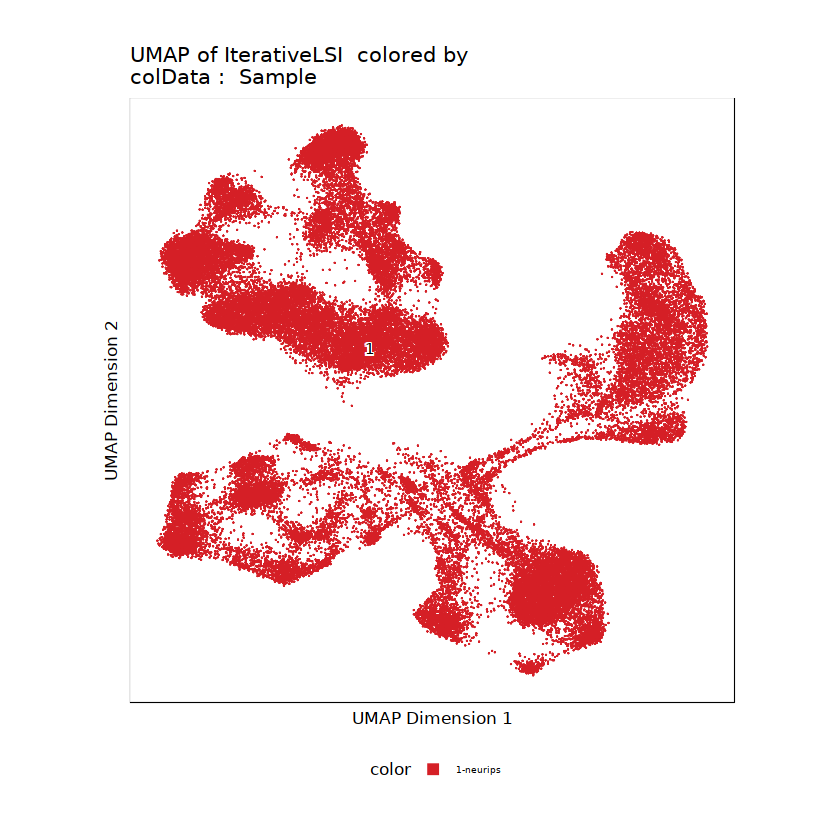

In [104]:
p1 <- plotEmbedding(ArchRProj = proj, embedding = "UMAP")
p1

In [169]:
unique(metadata[['batch']])

[1] "s1d1"  "s1d2"  "s1d3"  "s2d1"  "s2d4"  "s2d5"  "s3d10" "s3d3"  "s3d6" 
[10] "s3d7"  "s4d1"  "s4d8"  "s4d9"

In [162]:
unique(metadata[['batch']])

[1] "s1d1"  "s1d2"  "s1d3"  "s2d1"  "s2d4"  "s2d5"  "s3d10" "s3d3"  "s3d6" 
[10] "s3d7"  "s4d1"  "s4d8"  "s4d9"

In [163]:
unique(cellnames[,2])

[1] "1"  "2"  "3"  "4"  "5"  "6"  "10" "8"  "12" "14" "13"

In [148]:
metadata[['barcodes']] <- str_c(cellnames[['barcode']], cellnames[['sample']], sep='-')

In [149]:
nrow(metadata)

[1] 62501

In [150]:
cellcoldata <- getCellColData(proj)

In [151]:
nrow(cellcoldata)

[1] 44809

In [152]:
cellcoldata <- merge(cellcoldata, metadata, by='barcodes', all.x=TRUE, duplicateGeoms=FALSE)

In [153]:
nrow(cellcoldata)

[1] 44867

In [139]:
nrow(cellcoldata)

[1] 44867

In [156]:
huh <- unique(metadata[['barcodes']])

In [158]:
length(huh)

[1] 62433

In [134]:
proj$cell_type = cellcoldata$cell_type

ERROR: Error in `[[<-`(`*tmp*`, i, value = new("Rle", values = c("CD16+ Mono", : 44867 elements in value to replace 44809 elements


In [130]:
?addCellColData

addCellColData {ArchR},R Documentation
ArchRProj,An ArchRProject object.
data,The data to add to cellColData.
name,"The column header name to be used for this new data in cellColData. If a column with this name already exists, you may set force equal to TRUE to overwrite the data in this column."
cells,The names of the cells corresponding to data. Typically new data is added to all cells but you may use this argument to only add data to a subset of cells. Cells where data is not added are set to NA.
force,A boolean value indicating whether or not to overwrite data in a given column when the value passed to name already exists as a column name in cellColData.


In [115]:
metadata

V1,nCount_peaks,atac_fragments,reads_in_peaks_frac,blacklist_fraction,nucleosome_signal,cell_type,pseudotime_order_ATAC,batch,pseudotime_order_GEX,is_train,size_factor,barcodes
<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<lgl>,<dbl>,<chr>
TAGTTGTCACCCTCAC-1-s1d1,4031,5400,0.7464815,0.0034730836,0.6424682,Naive CD20+ B,NA,s1d1,NA,TRUE,3956,TAGTTGTCACCCTCAC-1
CTATGGCCATAACGGG-1-s1d1,8636,19266,0.4482508,0.0031264474,1.2206790,CD14+ Mono,NA,s1d1,NA,TRUE,8232,CTATGGCCATAACGGG-1
CCGCACACAGGTTAAA-1-s1d1,4674,6177,0.7566780,0.0012836970,0.6925734,CD8+ T,NA,s1d1,NA,TRUE,4635,CCGCACACAGGTTAAA-1
TCATTTGGTAATGGAA-1-s1d1,2803,4019,0.6974372,0.0007135212,0.6338384,CD8+ T,NA,s1d1,NA,TRUE,2771,TCATTTGGTAATGGAA-1
ACCACATAGGTGTCCA-1-s1d1,1790,2568,0.6970405,0.0033519553,0.7276596,CD16+ Mono,NA,s1d1,NA,TRUE,1737,ACCACATAGGTGTCCA-1
TGGATTGGTTTGCGAA-1-s1d1,2825,3828,0.7379833,0.0000000000,0.5352798,B1 B,NA,s1d1,NA,TRUE,2754,TGGATTGGTTTGCGAA-1
GTGAGCGAGTAAAGGT-1-s1d1,10802,18539,0.5826636,0.0025921126,1.0166445,Lymph prog,NA,s1d1,NA,TRUE,10503,GTGAGCGAGTAAAGGT-1
GACTTAGGTTGCGCGA-1-s1d1,4540,6723,0.6752938,0.0017621145,0.7714286,CD4+ T naive,NA,s1d1,NA,TRUE,4483,GACTTAGGTTGCGCGA-1
GCCTTACTCGTTACAA-1-s1d1,26624,37895,0.7025729,0.0027043269,0.8506173,CD4+ T activated,NA,s1d1,NA,TRUE,26291,GCCTTACTCGTTACAA-1


In [106]:
metadata['barcodes'] = 

V1,nCount_peaks,atac_fragments,reads_in_peaks_frac,blacklist_fraction,nucleosome_signal,cell_type,pseudotime_order_ATAC,batch,pseudotime_order_GEX,is_train,size_factor
<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<lgl>,<dbl>
TAGTTGTCACCCTCAC-1-s1d1,4031,5400,0.7464815,0.0034730836,0.6424682,Naive CD20+ B,NA,s1d1,NA,TRUE,3956
CTATGGCCATAACGGG-1-s1d1,8636,19266,0.4482508,0.0031264474,1.2206790,CD14+ Mono,NA,s1d1,NA,TRUE,8232
CCGCACACAGGTTAAA-1-s1d1,4674,6177,0.7566780,0.0012836970,0.6925734,CD8+ T,NA,s1d1,NA,TRUE,4635
TCATTTGGTAATGGAA-1-s1d1,2803,4019,0.6974372,0.0007135212,0.6338384,CD8+ T,NA,s1d1,NA,TRUE,2771
ACCACATAGGTGTCCA-1-s1d1,1790,2568,0.6970405,0.0033519553,0.7276596,CD16+ Mono,NA,s1d1,NA,TRUE,1737
TGGATTGGTTTGCGAA-1-s1d1,2825,3828,0.7379833,0.0000000000,0.5352798,B1 B,NA,s1d1,NA,TRUE,2754
GTGAGCGAGTAAAGGT-1-s1d1,10802,18539,0.5826636,0.0025921126,1.0166445,Lymph prog,NA,s1d1,NA,TRUE,10503
GACTTAGGTTGCGCGA-1-s1d1,4540,6723,0.6752938,0.0017621145,0.7714286,CD4+ T naive,NA,s1d1,NA,TRUE,4483
GCCTTACTCGTTACAA-1-s1d1,26624,37895,0.7025729,0.0027043269,0.8506173,CD4+ T activated,NA,s1d1,NA,TRUE,26291
